# Introduction
`fastai` is a free deep learning API built on [PyTorch V1](https://pytorch.org/). The [fast.ai team](https://www.fast.ai/2018/10/02/fastai-ai/) incorporates their reseach breakthroughs into the software, enabling users to achieve more accurate results faster and with fewer lines of code.

This kernel illustrates the simplicity of deploying the `fastai.vision` package for image classification tasks. I am in no way a domain expert in this topic, in fact having no domain knowledge at all before this competition! I will heavily rely on published kernels (which are all referenced under [Acknowledgements](#Acknowledgements)) in guidance for setting hyperparameters in this task.

I will be deploying standard techniques taught in the fast.ai course to see how well these techniques can perform without needing expert knowledge. The techniques are:
1. Learning rate finder
2. 1-cycle learning
3. Differential learning rates for model finetuning
4. Data augmentation
5. Test time augmentation
6. Transfer learning via low-resolution images

This kernel had the previous name of **Minimal fast.ai kit for image classification**, which is a slight misnomer now, considering the detailed techniques being deployed in this image classification task.

# Contents
1. [Skeleton code](#Skeleton-code)
* [Import packages](#Import-packages)
* [Exploratory data analysis](#Exploratory-data-analysis)
* [Data loading and preparation](#Data-loading-and-preparation)
* [Model creation](#Model-creation)
* [Model training](#Model-training).
* [Model interpretation](#Model-interpretation)
* [Transfer learning](#Transfer-learning)
* [Generating submission](#Generating-submission)
* [Future work](#Future-work)
* [Acknowledgements](#Acknowledgements)

# Skeleton code

Following from the initial idea of showing the simplicity of using the `fastai` library, below is a code snippet containing 27 lines of code using default settings for a base model generation. Of these 27 lines, 10 lines are used to generate the submission file for the required format.
```
from fastai import *
from fastai.vision import *

data = ImageDataBunch.from_csv(path, folder = 'train', csv_labels = "train_labels.csv",
                               test = 'test',suffix=".tif", size = 36, ds_tfms = get_transforms())
data.path = pathlib.Path('.')
data.normalize(imagenet_stats)

learn = create_cnn(data,resnet50,pretrained = True,metrics = accuracy)
learn.fit_one_cycle(5)

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(3,max_lr = slice(1e-6,3e-4))

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)
interp.plot_confusion_matrix()
preds,y = learn.TTA()
acc = accuracy(preds, y)
print('The validation accuracy is {} %.'.format(acc * 100))

def generateSubmission(learner):
    submissions = pd.read_csv('../input/sample_submission.csv')
    id_list = list(submissions.id)
    preds,y = learner.TTA(ds_type=DatasetType.Test)
    pred_list = list(preds[:,1])
    pred_dict = dict((key, value.item()) for (key, value) in zip(learner.data.test_ds.items,pred_list))
    pred_ordered = [pred_dict[Path('../input/test/' + id + '.tif')] for id in id_list]
    submissions = pd.DataFrame({'id':id_list,'label':pred_ordered})
    submissions.to_csv("submission_{}.csv".format(pred_score),index = False)
 
 generateSubmission(learn)
```

# Import packages

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
!pip install "torch===1.4.0" "torchvision==0.5.0" "pytorchcv" "utils" "pretrainedmodels" "nbdev" "fire" "nbconvert" "gpustat" "curses-menu" "nvidia-smi"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 46.2MB/s 
     |████████████████████████████████| 440kB 42.6MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 256kB 50.4MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=f65db3227b3db61fd8700f9c89945a7246fc0bd7409b2cb35bec265ccabe19c1
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for fire: filename=fire-0.3.1-py2.py3-none-any.whl size=111005 sha256=cf6fdddf8a22a8e429c565076df5b799f25c07f43f7dab3980c71746cd59dbbd
  Stored in directory: /root/.cache/pip/wheels/c1/61/df/768b03527bf006b546dce284eb4249b185669e65afc5fbb2ac
  Created wheel for gp

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from torchvision.models import *

from pytorchcv.model_provider import get_model as ptcv_get_model
import torch
from torch.autograd import Variable
import pretrainedmodels

import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
from utils import *
from nbdev.showdoc import *

In [0]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
Tesla K80


In [0]:
!gpustat

7c07f2ff5f7a         Sat May  9 13:19:02 2020  418.67
[0] Tesla K80        | 33'C,   0 % |    11 / 11441 MB |


In [0]:
!nvidia-smi

Sat May  9 13:19:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/UCB Bootcamp/Final Project"

COVID-AI-densenet121.ipynb  COVID-CT-rn50
covid_all.csv		    covid_positive.csv
covid_all_tags-2.csv	    CT_COMBINED
covid_all_tags-3.csv	    export.pkl
covid_all_tags.csv	    Final_Report_densenet121-256px.csv
COVID-CT-densenet121-2.pkl  Final_Report_densenet121.csv
COVID-CT-densenet121-3.pkl  Final_Report_resnet34.csv
COVID-CT-densenet121-4.pkl  Final_Report_resnet50.csv
COVID-CT-densenet121-5.pkl  medical-website-background-images-7.jpg
COVID-CT-densenet121.pkl    models
COVID-CT-rn34


In [0]:
#!ls "/content/drive/My Drive/UCB Bootcamp/Final Project/CT_COMBINED"

# Exploratory data analysis

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

path = Path("/content/drive/My Drive/UCB Bootcamp/Final Project/")
folder='CT_COMBINED'

df = pd.read_csv(path/"covid_all_tags-3.csv")
df

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,image_name,tags
0,2020.03.18.20038125-p16-56-6.png,"2019-nCoV-Positive:Severe:""Diamond Princess"" C..."
1,2020.03.18.20038125-p16-56-5.png,"2019-nCoV-Positive:Severe:""Diamond Princess"" C..."
2,2020.03.18.20038125-p16-56-4.png,"2019-nCoV-Positive:Severe:""Diamond Princess"" C..."
3,2020.03.18.20038125-p16-56-3.png,"2019-nCoV-Positive:Severe:""Diamond Princess"" C..."
4,2020.03.18.20038125-p16-56-2.png,"2019-nCoV-Positive:Severe:""Diamond Princess"" C..."
...,...,...
741,10%0.png,2019-nCoV-Negative
742,1%2.png,2019-nCoV-Negative
743,1%1.png,2019-nCoV-Negative
744,1%0.png,2019-nCoV-Negative


In [0]:
tfms = get_transforms()

In [0]:
np.random.seed(42) # set random seed so we always get the same validation set
src = (ImageList.from_csv(path, 'covid_all_tags-3.csv', folder='CT_COMBINED', suffix='')
       # Load data from csv
       .split_by_rand_pct(0.2)
       # split data into training and validation set (20% validation)
       .label_from_df(label_delim=':')
       # label data using the tags column (second column is default)
)

In [0]:
data = (src.transform(size=128) #
        .databunch().normalize(imagenet_stats))

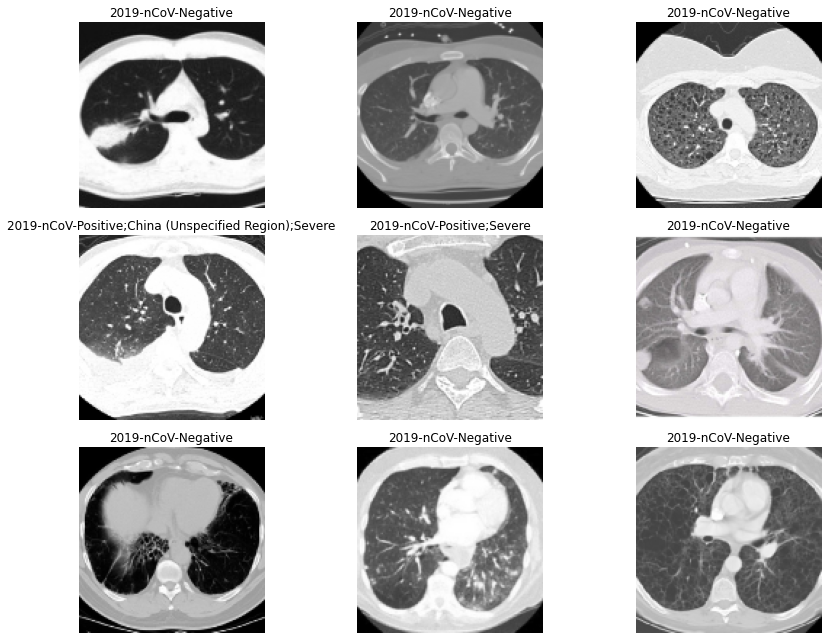

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
#print(pretrainedmodels.model_names)

In [0]:
arch = models.resnet34
arch = models.resnet50
arch = models.densenet121

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


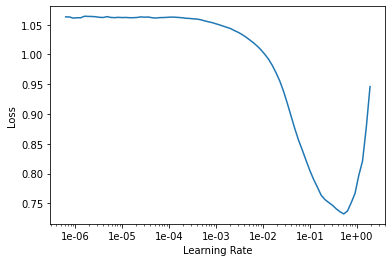

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,1.032855,0.940297,0.152329,0.127207,00:24
1,0.958101,0.708277,0.191682,0.124609,00:06
2,0.808644,0.282720,0.585926,0.191954,00:06
3,0.605371,0.102352,0.971019,0.599506,00:06
4,0.459624,0.091033,0.974781,0.682543,00:06
5,0.359051,0.077684,0.977324,0.727621,00:06
6,0.287515,0.072184,0.979459,0.756329,00:06
7,0.234119,0.072399,0.979967,0.748680,00:06
8,0.194112,0.070377,0.980476,0.757053,00:06
9,0.162802,0.068787,0.980069,0.758756,00:06


In [0]:
#learn.save('COVID-CT-stage-1-rn50')

In [0]:
#learn.save('COVID-CT-stage-1-rn34')

In [0]:
#learn.save('COVID-CT-stage-1-densenet121')

In [0]:
learn.save('COVID-CT-stage-1-densenet121-128px')

# Time to fine tune our model...

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


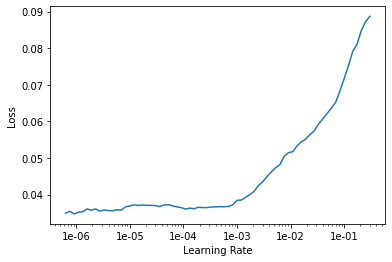

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# fit model with differential learning rates
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.038440,0.061754,0.980273,0.779437,00:07
1,0.037127,0.077181,0.978341,0.704675,00:07
2,0.038406,0.080687,0.981391,0.761305,00:07
3,0.036424,0.063935,0.982713,0.779770,00:07
4,0.033513,0.059823,0.982408,0.780589,00:07


In [0]:
#learn.save('COVID-CT-stage-2-rn34-128px')

In [0]:
#learn.save('COVID-CT-stage-2-rn50-128px')

In [0]:
#learn.save('COVID-CT-stage-2-densenet121')

In [0]:
learn.save('COVID-CT-stage-2-densenet121-128px')

# Switch resolution to further fine tune our model and prevent overfitting:

In [0]:
data = (src.transform(size=256)
        .databunch(bs=16).normalize(imagenet_stats))
learn.data = data

In [0]:
learn.freeze() # freeze bottom layers again

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


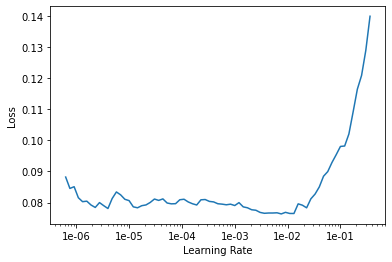

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.075115,0.059854,0.979662,0.787462,00:18
1,0.066634,0.060508,0.976815,0.777560,00:15
2,0.055821,0.057406,0.982306,0.809753,00:15
3,0.044508,0.049963,0.984340,0.827394,00:15
4,0.035905,0.051125,0.983527,0.818785,00:15


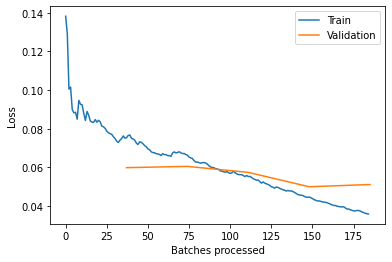

In [0]:
learn.recorder.plot_losses()

In [0]:
# find out how to input data and validate

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.027091,0.051225,0.984442,0.830691,00:22
1,0.027763,0.050092,0.984849,0.828466,00:20
2,0.025481,0.050744,0.984543,0.813441,00:20
3,0.024824,0.050138,0.983628,0.815159,00:20
4,0.022535,0.051897,0.985255,0.823181,00:20
5,0.019802,0.051186,0.985560,0.828295,00:20
6,0.018137,0.049453,0.984849,0.818405,00:20
7,0.017159,0.052033,0.985560,0.827723,00:20
8,0.015658,0.050815,0.985459,0.829405,00:20
9,0.015235,0.049940,0.985764,0.832600,00:20


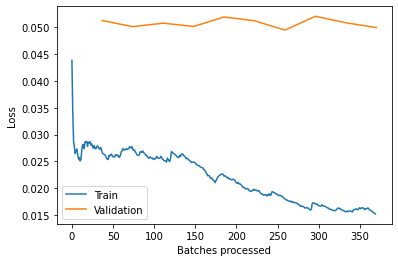

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('COVID-CT-stage-2-densenet121-256px')

In [0]:
#learn.export('COVID-CT-rn50')

In [0]:
#learn.export('COVID-CT-rn34')

In [0]:
learn.export('COVID-CT-densenet121-5.pkl')

In [0]:
#learn.export()

In [0]:
dataframes = []


for directory in ('CT-COMBINED'):
    test = ImageList.from_folder(path/folder)
    learn = load_learner(path, test=test)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    thresh = 0.2
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
    dataframes.append(df)

final_df = pd.concat(dataframes)
#final_df.to_csv(path/'Final_Report_densenet121.csv', index=False)
final_df.head()

,image_name,tags
0,174,2019-nCoV-Negative
1,1702,2019-nCoV-Negative 2019-nCoV-Positive N/A
2,1310,2019-nCoV-Negative 2019-nCoV-Positive
3,709,2019-nCoV-Negative
4,781,2019-nCoV-Negative


In [0]:
final_df

,image_name,tags
0,174,2019-nCoV-Negative
1,1702,2019-nCoV-Negative 2019-nCoV-Positive N/A
2,1310,2019-nCoV-Negative 2019-nCoV-Positive
3,709,2019-nCoV-Negative
4,781,2019-nCoV-Negative
...,...,...
741,88,2019-nCoV-Negative
742,86,2019-nCoV-Negative
743,91%0,2019-nCoV-Negative
744,90,2019-nCoV-Negative


# Future work

1. [DONE] Generate sample submission to ensure functional code. (0.6007)
2. [DONE] Implement skeleton model for baseline (0.9106).
3. [DONE] Prepare AUC metric (0.9233).
4. [DONE] Deploy reasoned data augmentation (0.9241).
5. [DONE] Deploy test-time augmentation (0.9364).
6. Test other architectures (which are found [here in the Pytorch docs](https://pytorch.org/docs/stable/torchvision/models.html))
    1. [DONE] ResNet-34 (0.9362)
    2. [DONE] DenseNet-169 (0.9370)
7. [DONE] Implement weight decay. (0.9368)
8. [DONE] Retrain model with higher resolution images. (0.9573)